# TP : Image Captioning avec Réseau de Neurones et Attention

## Objectifs du TP

- Comprendre le principe de l’**image captioning** : générer une description textuelle à partir d’une image.  
- Utiliser un **extracteur de caractéristiques** pré-entraîné (ResNet).  
- Mettre en place un **RNN avec mécanisme d’attention** pour générer les phrases.  
- Préparer les données (tokenisation, padding, normalisation).  
- Entraîner, évaluer et interpréter les performances du modèle.  
- Visualiser des exemples de captions générées pour analyser la qualité des résultats.


## **Imports et configuration de l'environnement**

In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import Flickr30k
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
kaggle_caption_file = "/kaggle/input/flickr30k/captions.txt"
output_ann_file = "/kaggle/working/results_20130124.token"

with open(kaggle_caption_file, "r", encoding="utf-8") as f_in, \
     open(output_ann_file, "w", encoding="utf-8") as f_out:

    next(f_in)  # ignorer header
    for line in f_in:
        parts = line.strip().split(",", 2)
        if len(parts) == 3:
            image, idx, caption = parts
            f_out.write(f"{image}#{idx}\t{caption}\n")

print(" Fichier d'annotations généré")


 Fichier d'annotations généré


## **Définition des transformations des images**

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
root = "/kaggle/input/flickr30k/flickr30k_images"
ann_file = "/kaggle/working/results_20130124.token"

dataset = Flickr30k(
    root=root,
    ann_file=ann_file,
    transform=transform
)

print("Dataset size:", len(dataset))

Dataset size: 31783


## **Fonction de collate pour le DataLoader**

In [5]:
import random

MAX_LEN = 20

def collate_fn(batch):
    images = []
    captions = []

    for img, cap_list in batch:
        images.append(img)

        # Flickr30k → liste de captions
        caption = random.choice(cap_list)

        tokens = tokenize(caption, word2idx, MAX_LEN)
        captions.append(tokens)

    images = torch.stack(images)
    captions = torch.tensor(captions, dtype=torch.long)

    return images, captions


## **Séparation du dataset et création des DataLoaders**

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    collate_fn=collate_fn
)


print("Train:", len(train_dataset))
print("Test :", len(test_dataset))


Train: 25426
Test : 6357


## **Affichage d’une image avec ses légendes brutes**

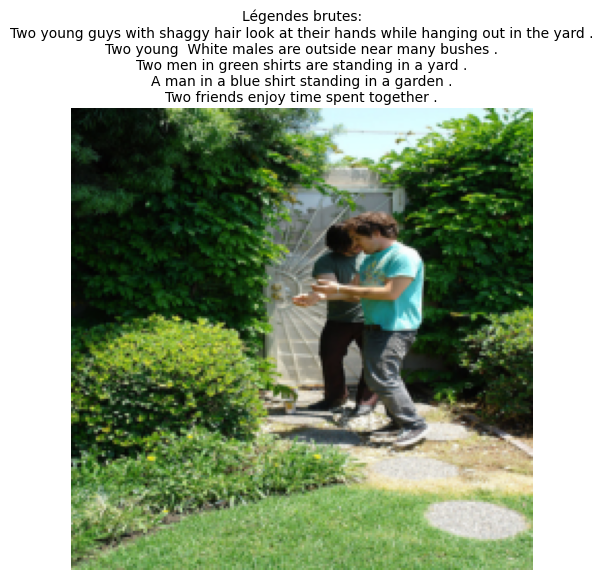

In [55]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

img_show = denormalize(img).clamp(0, 1)  

plt.figure(figsize=(6,6))
plt.imshow(TF.to_pil_image(img_show))
plt.axis("off")
plt.title("Légendes brutes:\n" + "\n".join(captions_list), fontsize=10, wrap=True)
plt.show()


## **Fonctions de tokenization et detokenization**

In [8]:
def tokenize(sentence, word2idx, max_len=20):
    tokens = [0]
    for word in sentence.lower().split():
        if word in word2idx:
            tokens.append(word2idx[word])
    return tokens[:max_len] + [0] * (max_len - len(tokens))

def untokenize(tokens, idx2word):
    return [idx2word[t] for t in tokens if t != 0]


## **Construction du vocabulaire**

In [11]:
vocabulary = set()

with open(ann_file, "r", encoding="utf-8") as f:
    for line in f:
        _, caption = line.strip().split("\t")
        for word in caption.lower().split():
            vocabulary.add(word)

print("Vocabulary size:", len(vocabulary))


Vocabulary size: 20331


In [12]:
def create_embedding_layer(vocab, emb_dim=300):
    idx2word = ["<PAD>"]
    word2idx = {"<PAD>": 0}
    weights = [np.zeros((1, emb_dim))]

    for word in vocab:
        idx2word.append(word)
        word2idx[word] = len(word2idx)
        weights.append(np.random.normal(scale=0.6, size=(1, emb_dim)))

    weights = np.concatenate(weights, axis=0)

    emb = nn.Embedding(len(idx2word), emb_dim)
    emb.weight.data.copy_(torch.tensor(weights))
    emb.weight.requires_grad = False

    return emb, idx2word, word2idx

embedding_layer, idx2word, word2idx = create_embedding_layer(vocabulary)
print("Embedding shape:", embedding_layer.weight.shape)


Embedding shape: torch.Size([20332, 300])


In [13]:
imgs, caps = next(iter(train_loader))
print(imgs.shape)     
print(caps.shape)     
print(caps[0])

torch.Size([32, 3, 224, 224])
torch.Size([32, 20])
tensor([    0, 11393, 12167, 15431, 10062, 13793, 17777, 10918, 13793, 10567,
         2363, 19158,  8823, 14056, 11393, 19564, 15431, 16623,  2051, 15277])


## **Préparation du ResNet50 pour l’extraction de caractéristiques**

In [14]:
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
cnn = nn.Sequential(*list(resnet.children())[:-2]).to(device)

for p in cnn.parameters():
    p.requires_grad = False

cnn.eval()
print("ResNet50 prêt")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] 


ResNet50 prêt


## **Module d’attention**

In [15]:
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, att_dim):
        super().__init__()
        self.f_att = nn.Linear(feature_dim, att_dim)
        self.h_att = nn.Linear(hidden_dim, att_dim)
        self.fc = nn.Linear(att_dim, 1)

    def forward(self, features, hidden):
        att = self.fc(
            torch.tanh(self.f_att(features) + self.h_att(hidden).unsqueeze(1))
        ).squeeze(2)

        alpha = F.softmax(att, dim=1)
        context = (features * alpha.unsqueeze(2)).sum(dim=1)
        return context


## **LSTM avec intégration de l’attention**

In [16]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, att_module, feat_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.att = att_module

        concat_dim = input_dim + hidden_dim + feat_dim
        self.Wi = nn.Linear(concat_dim, hidden_dim)
        self.Wf = nn.Linear(concat_dim, hidden_dim)
        self.Wc = nn.Linear(concat_dim, hidden_dim)
        self.Wo = nn.Linear(concat_dim, hidden_dim)

    def forward(self, embeddings, features):
        B, T, _ = embeddings.size()
        h = torch.zeros(B, self.hidden_dim).to(embeddings.device)
        c = torch.zeros_like(h)
        outputs = []

        for t in range(T):
            x = embeddings[:, t]
            ctx = self.att(features, h)
            z = torch.cat([x, h, ctx], dim=1)

            i = torch.sigmoid(self.Wi(z))
            f = torch.sigmoid(self.Wf(z))
            o = torch.sigmoid(self.Wo(z))
            c_hat = torch.tanh(self.Wc(z))

            c = f * c + i * c_hat
            h = o * torch.tanh(c)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1)


## **Modèle complet ImageCaptioningModel**

In [17]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn, emb, vocab_size):
        super().__init__()
        self.cnn = cnn
        self.emb = emb
        self.att = Attention(2048, 512, 256)
        self.lstm = LSTMWithAttention(300, 512, self.att, 2048)
        self.fc = nn.Linear(512, vocab_size)

    def forward(self, images, captions):
        feat = self.cnn(images)
        feat = feat.permute(0, 2, 3, 1).reshape(images.size(0), -1, 2048)
        emb = self.emb(captions)
        out = self.lstm(emb, feat)
        return self.fc(out)


## **Définition du modèle, critère et optimiseur**

In [18]:
model = ImageCaptioningModel(
    cnn=cnn,
    emb=embedding_layer,
    vocab_size=len(idx2word)
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=100, gamma=0.1
)


## **Fonction de génération de caption**

In [22]:
def generate_caption(model, image, max_len=20):
    model.eval()

    with torch.no_grad():
        # Image
        image = image.unsqueeze(0).to(device)

        # CNN features
        features = model.cnn(image)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))

        # <PAD> = 0
        caption = [0]

        for _ in range(max_len - 1):
            caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)
            embeddings = model.emb(caption_tensor)

            lstm_out = model.lstm(embeddings, features)
            outputs = model.fc(lstm_out)

            next_word = outputs[0, -1].argmax().item()
            caption.append(next_word)

        words = untokenize(caption, idx2word)

    return " ".join(words)


## **Boucle d’entraînement du modèle**

In [23]:
num_epochs = 50 

model.train()
for epoch in range(num_epochs):
    total_loss = 0

    for i, (imgs, caps) in enumerate(train_loader):
        imgs = imgs.to(device)
        caps = caps.to(device)

        inp = caps[:, :-1]
        tgt = caps[:, 1:]

        out = model(imgs, inp)

        loss = criterion(
            out.reshape(-1, out.size(-1)),
            tgt.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch {epoch+1} | Step {i} | Loss {loss.item():.4f}")

    scheduler.step()

    sample_img, _ = dataset[0]
    print("Generated caption:", generate_caption(model, sample_img.to(device)))
    print("Epoch loss:", total_loss / len(train_loader))


Epoch 1 | Step 0 | Loss 3.6316
Epoch 1 | Step 10 | Loss 3.9749
Epoch 1 | Step 20 | Loss 3.8762
Epoch 1 | Step 30 | Loss 3.5642
Epoch 1 | Step 40 | Loss 3.4588
Epoch 1 | Step 50 | Loss 3.5360
Epoch 1 | Step 60 | Loss 3.6783
Epoch 1 | Step 70 | Loss 3.8144
Epoch 1 | Step 80 | Loss 3.5058
Epoch 1 | Step 90 | Loss 3.6534
Epoch 1 | Step 100 | Loss 3.5392
Epoch 1 | Step 110 | Loss 3.9210
Epoch 1 | Step 120 | Loss 3.5527
Epoch 1 | Step 130 | Loss 3.6926
Epoch 1 | Step 140 | Loss 3.7628
Epoch 1 | Step 150 | Loss 3.7131
Epoch 1 | Step 160 | Loss 3.5527
Epoch 1 | Step 170 | Loss 3.3066
Epoch 1 | Step 180 | Loss 3.6035
Epoch 1 | Step 190 | Loss 3.5023
Epoch 1 | Step 200 | Loss 3.8291
Epoch 1 | Step 210 | Loss 3.9353
Epoch 1 | Step 220 | Loss 3.6935
Epoch 1 | Step 230 | Loss 3.3792
Epoch 1 | Step 240 | Loss 3.5204
Epoch 1 | Step 250 | Loss 3.5624
Epoch 1 | Step 260 | Loss 3.4068
Epoch 1 | Step 270 | Loss 3.6245
Epoch 1 | Step 280 | Loss 3.6073
Epoch 1 | Step 290 | Loss 3.5708
Epoch 1 | Step 300 | 

## **Evaluation du modèle**

In [29]:
import matplotlib.pyplot as plt

### Génération d’une caption pour trois image

Generated caption:
five girls are jumping in the air in a dance studio . . """ . """ . """ .


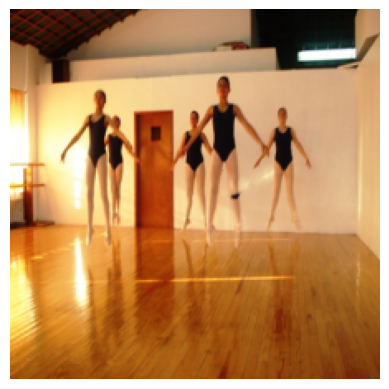

In [30]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean


img, _ = dataset[10]

plt.imshow(denormalize(img).permute(1,2,0).clamp(0,1))
plt.axis("off")

print("Generated caption:")
print(generate_caption(model, img))

Generated caption:
a young man in a blue and yellow jacket is gazing at the end of a young man .


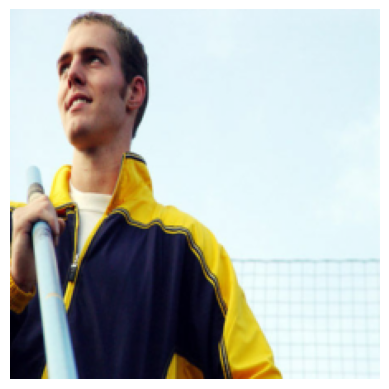

In [46]:
img, _ = dataset[30]

plt.imshow(denormalize(img).permute(1,2,0).clamp(0,1))
plt.axis("off")

print("Generated caption:")
print(generate_caption(model, img))

Generated caption:
a woman in a black shirt with a black pot over her bundt cake . up her bundt .


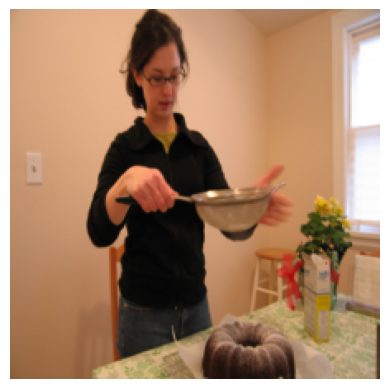

In [49]:
img, _ = dataset[15]

plt.imshow(denormalize(img).permute(1,2,0).clamp(0,1))
plt.axis("off")

print("Generated caption:")
print(generate_caption(model, img))

### Évaluation du modèle sur l’ensemble de test

In [39]:
import math
import torch
import torchvision.transforms.functional as TF

model.eval()

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(img.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(img.device)
    return img * std + mean

In [40]:
test_loss = 0

with torch.no_grad():
    for imgs, caps in test_loader:
        imgs = imgs.to(device)
        caps = caps.to(device)

        inp = caps[:, :-1]
        tgt = caps[:, 1:]

        out = model(imgs, inp)

        loss = criterion(
            out.reshape(-1, out.size(-1)),
            tgt.reshape(-1)
        )

        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test loss : {test_loss:.4f}")

Test loss : 4.3411


### Visualisation de captions générées sur des exemples de test

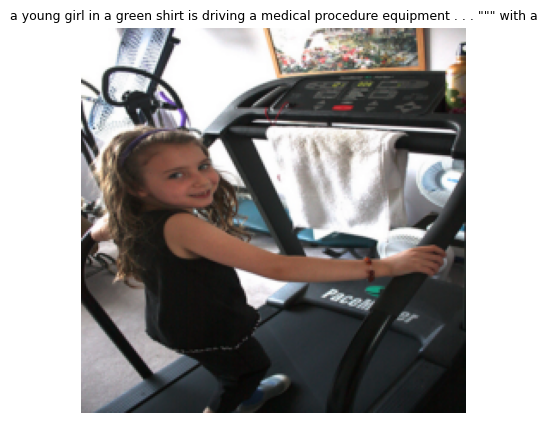

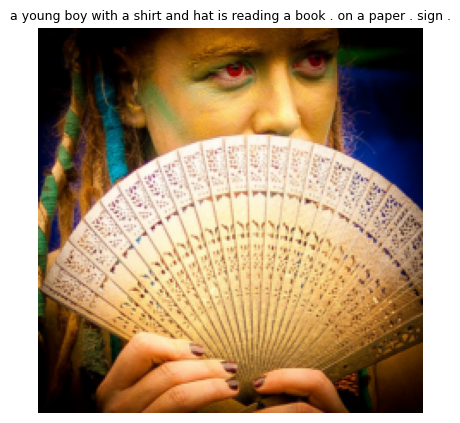

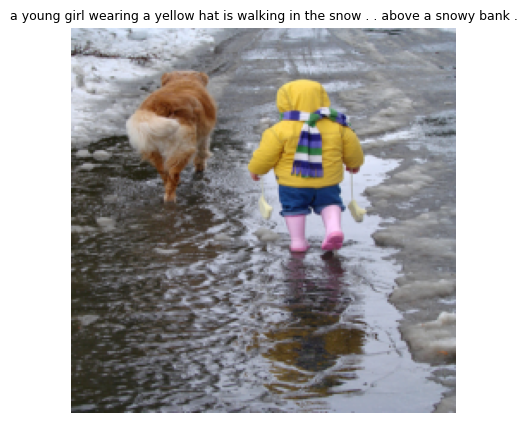

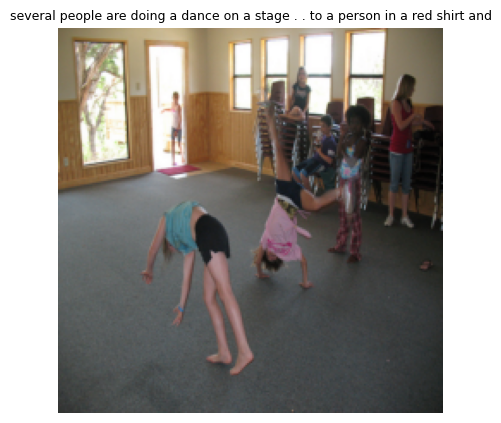

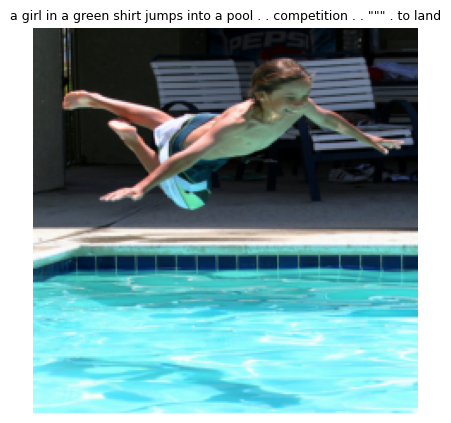

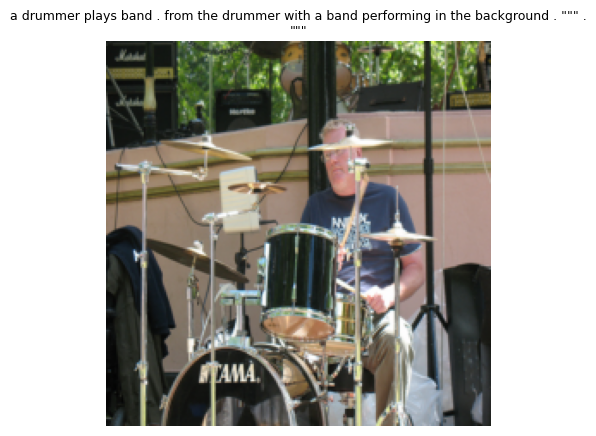

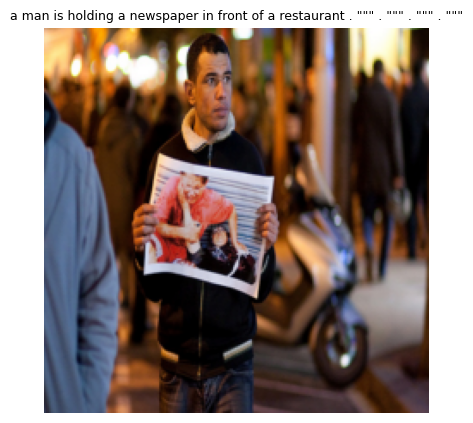

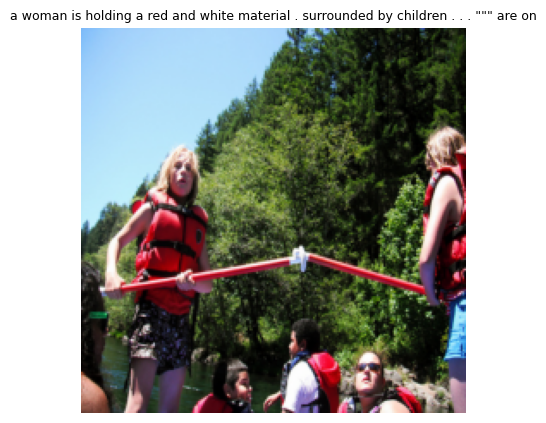

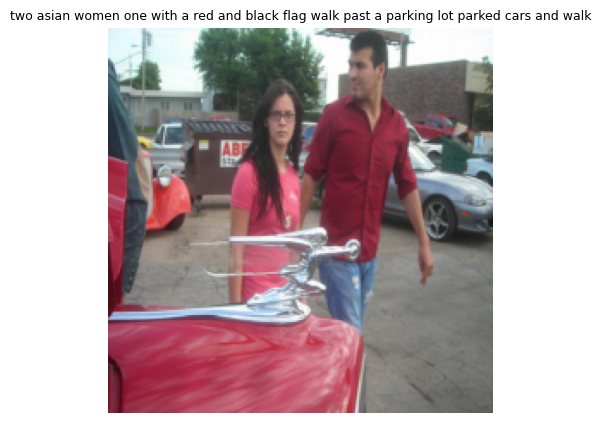

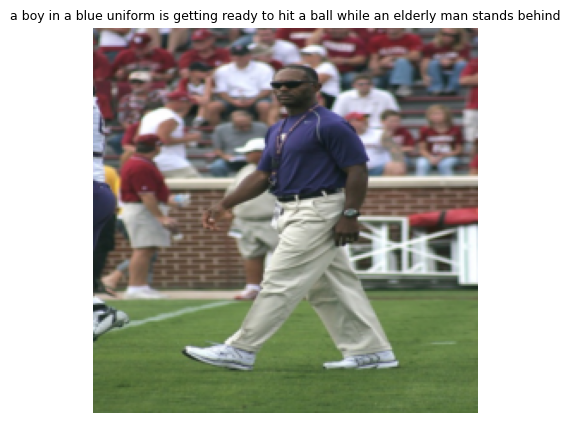

In [44]:
num_examples = 10

with torch.no_grad():
    for i in range(num_examples):
        img, _ = test_dataset[i]

        caption = generate_caption(model, img.to(device))
        img_show = denormalize(img).cpu()

        plt.figure(figsize=(6, 5))
        plt.imshow(TF.to_pil_image(img_show))
        plt.axis("off")
        plt.title(caption, fontsize=9, wrap=True)
        plt.show()